### 1. Settings 

In [43]:
import warnings
warnings.filterwarnings("ignore")
import os,pickle,sys,re,glob
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from importlib import reload
#customized module
from fun import network_analysis, predictive_model, validation
import seaborn as sns; sns.set_theme(color_codes=True);sns.set_style("white")
from fun import utilities as ut
%matplotlib inline

cwd = os.getcwd()
datapath='/efs/bioinformatics/projects/tb-gene-signature/working-folder'
outputpath=cwd+'/data/update'
valdata_dir = datapath+'/../validation-dataset'
#viral infection data directory
vinf_dir = datapath+'/../validation-dataset/viral-infection-dataset'
#final model directory
final_ml_dir = datapath+'/pickled-files/final-ML-model/opt_score_rocauc_20220224'
pickled_objects_dir = datapath+'/pickled-files'
#data to be shared in the publication
publication_dir=outputpath

#For coding, if necessary
random_state=1#for creating randomized model
cpu=60 #cpu=-1 use all processors
reload(predictive_model);reload(ut);reload(validation)
gpmod=predictive_model.predModelClass(cwd,datapath,outputpath,pickled_objects_dir,random_state,cpu)
gval=validation.valModelClass(cwd,datapath,outputpath,random_state,valdata_dir)

rescale=1

#### Viral infection transcriptomic data collection (WB or PBMC)

In [73]:
def viral_data_extract(name, i_col, i_col_new, ageUnit='year'):
    data = pd.read_csv(vinf_dir+'/'+name+'_array_Exp_EachGene.csv',sep=',',index_col=0)
    data.index=[ut.genealias(x) for x in data.index]
    info = pd.read_csv(vinf_dir+'/'+name+'_array_Exp_Info.csv',sep=',',index_col=0)
    info=info.loc[:,i_col]
    info.columns=i_col_new
    
    if name=='GSE111368_GPL10558':
        info['disease']='Influenza'
        info.loc[info.viral_group=='HC','disease']='HC'
    if name=='GSE17156_GPL571':
        #Change pre-challenge (baseline) to healthy
        info.loc[info['disease'].str.contains('baseline'),'disease']='healthy'
        info.disease=info.disease.replace(to_replace=r' challenge sample at T.*$', value='', regex=True)
    if name=='GSE20346_GPL6947':
        #only keep influenza samples
        info=info.loc[info['disease'].str.contains('Severe Influenza'),:]
        info.disease=info.disease.replace(to_replace=r'^Severe ', value='', regex=True)
        info['timepoint']=info['disease']
        info.disease=info.disease.replace(to_replace=r'_day.*$', value='', regex=True)
        info.timepoint=info.timepoint.replace(to_replace=r'^Influenza_', value='', regex=True)
    if name=='GSE21802_GPL6102':
        info['disease']='Influenza'
        info.loc[info.viral_group=='none','disease']='none'
        info['viral_group'] = info.viral_group.str.extract(r'\((.*) new subtype\)', expand=True)
    if 'GSE38900' in name:
        #Remove follow up samples
        info=info.loc[~info['disease'].str.contains('follow up'),:]
        info.loc[info['disease'].str.contains('healthy'),'disease']='healthy'
        info.loc[info['disease'].str.contains('RSV'),'disease']='RSV'
        info.loc[info['disease'].str.contains('HRV'),'disease']='Rhinovirus'
        info.loc[info['disease'].str.contains('Influenza A'),'disease']='Influenza A'
    if name=='GSE40012_GPL6947':
        #Only select influenza A samples 
        info=info.loc[info['disease'].str.contains('influenza A')|info['disease'].str.contains('healthy control'),:]
        info.loc[info['disease'].str.contains('influenza A'),'disease']='Influenza A'
        info.loc[info['disease'].str.contains('healthy control'),'disease']='healthy'
    if 'GSE6269' in name:
        info=info.loc[info['disease'].str.contains('Influenza A')|info['disease'].str.contains('Influenza B')|info['disease'].str.contains('None'),:]
    if name=='GSE67059_GPL6947':
        info.loc[info.disease=='HRV-','disease']='healthy'
        info.loc[info.disease=='HRV+','disease']='Rhinovirus'
    if name=='GSE68004_GPL10558':
        info=info.loc[info['disease'].str.contains('HAdV')|info['disease'].str.contains('healthy'),:]
        info.loc[info.disease=='HAdV','disease']='adenovirus'
    if name=='GSE68310_GPL10558':
        #Exclude timpoint=spring
        info=info.loc[(info.timepoint!='Spring')&(info.disease!='our tests did not detect one of the viruses sought'),:]
        #Change sample's disease status whose timepoint equal to baseline to healthy (prior to infection) 
        info.loc[info.timepoint=='Baseline','disease']='healthy'
        info.disease=info.disease.replace(to_replace=r'respiratory syncytial virus', value='RSV', regex=True)
        info.disease=info.disease.replace(to_replace=r'human | virus', value='', regex=True)
    if name=='GSE73072_GPL14604':
        info['disease']=info['viral_group']
        info['time']=[int(re.sub('hour ','',e)) for e in info.timepoint]
        #Change sample's disease status whose timepoint equal or less than hr 0 to healthy (prior to challenge) 
        info.loc[info.time<=0,'disease']='healthy'
        info.loc[(info.viral_group=='H1N1')|(info.viral_group=='H3N2'),'disease']='Influenza'
        info.loc[(info.viral_group=='HRV'),'disease']='Rhinovirus'
    if name=='GSE61821_GPL10558':
        info['disease']='Influenza'
        #only keep the acute stage or day 0 before treatment
        info=info.loc[info.viral_group!='OFI',:]
        info=info.loc[(info.timepoint=='Acute')|(info.timepoint=='day_0'),:]
    if name=='GSE61754_GPL10558':
        #Exclude vaccinee 
        info['disease']='Influenza'
        info=info.loc[(info.vaccination_status=='Control')|((info.vaccination_status=='Vaccinee')&(info.timepoint=='Pre-challenge')),:]
        info.loc[(info.timepoint=='Pre-challenge'),'disease']='healthy'
        
    #Entry adjust
    if ageUnit=='month':
        info.age=info.age/12
    info.loc[(info.disease=='Control')|(info.disease=='Healthy')|(info.disease=='HC')|(info.disease=='none')|(info.disease=='None'),'disease']='healthy'
    if 'gender' in info.columns:
        info.gender=info.gender.str.lower()
        info.loc[info.gender=='m','gender']='male'
        info.loc[info.gender=='f','gender']='female'
    #Only keep samples only existing in info
    data=data.loc[:,info.index]
    
    #print(name)
    #print(info.iloc[1:10,:])
    return info, data

def viral_infect_dataset(select_fea, rescale, pair):
    all_info_col=['Cohort','disease','viral_group','age','gender']
    all_info=pd.DataFrame([],columns=all_info_col)
    all_gset=pd.DataFrame([])

    #GSE101702 (Influenza:: influenza patients with varying severity of infection)
    info, data=viral_data_extract('GSE101702_GPL21185',['age:ch1','diagnosis:ch1','severity:ch1','Sex:ch1','tissue:ch1'],['age','disease','severity','gender','tissue'])
    info['Cohort']='GSE101702'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])

    #GSE103842 (RSV:: RSV infected infants)
    info, data=viral_data_extract('GSE103842_GPL10558',['age (in months):ch1','condition1:ch1','condition2:ch1','gender:ch1','tissue:ch1'],
                            ['age','disease','viral_group','gender','tissue'],ageUnit='month')
    info['Cohort']='GSE103842'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE111368 (Influenza:: patients with severe influenza with or without bacterial co-infection)
    info, data=viral_data_extract('GSE111368_GPL10558',['age:ch1','bacterial_status:ch1','day of illness:ch1','flu_type:ch1','Sex:ch1','subject id:ch1',
                            't1severity:ch1','timepoint:ch1'],['age','bacterial_status','day_illness','viral_group','gender','subjectID','severity','timepoint'])
    info['Cohort']='GSE111368'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE117827 (Rhinovirus, RSV, Enterovirus, Coxsackievirus:: children with acute viral infection)
    info, data=viral_data_extract('GSE117827_GPL23126',['age (months):ch1','gender:ch1','infection:ch1','symptomatic:ch1'],['age','gender','disease','symptomatic'],ageUnit='month')
    info['Cohort']='GSE117827'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE17156 (Influenza, Rhinovirus, RSV:: challenge study cohort)
    info, data=viral_data_extract('GSE17156_GPL571',['title','subject id:ch1','symptom group:ch1','timepoint:ch1'],['disease','subjectID','symptomatic','timepoint'])
    info['Cohort']='GSE17156'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE20346 (Influenza:: adults with CAP)
    info, data=viral_data_extract('GSE20346_GPL6947',['title','tissue:ch1'],['disease','tissue'])
    info['Cohort']='GSE20346'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE21802 (Influenza:: patients attending to the participants ICUs with primary viral pneumonia during the acute phase of influenza virus illness with acute respiratory distress 
    #and unequivocal alveolar opacification involving two or more lobes with negative respiratory and blood bacterial cultures at admission)
    info, data=viral_data_extract('GSE21802_GPL6102',['disease phase:ch1','mechanical ventilation:ch1','patient:ch1','tissue:ch1','virus strain:ch1'],
                            ['disease_phase','mechanical_ventilation','subjectID','tissue','viral_group'])
    info['Cohort']='GSE21802'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE38900 (RSV, Rhinovirus, Influenza:: Children with acute lower respiratory tract infection)
    info, data=viral_data_extract('GSE38900_GPL10558',['source_name_ch1','age:ch1','gender:ch1','tissue:ch1'],['disease','age','gender','tissue'],ageUnit='month')
    info['Cohort']='GSE38900'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    info, data=viral_data_extract('GSE38900_GPL6884',['source_name_ch1','age (months):ch1','gender:ch1','tissue:ch1'],['disease','age','gender','tissue'],ageUnit='month')
    info['Cohort']='GSE38900'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE40012 (Influenza:: adults with CAP)
    info, data=viral_data_extract('GSE40012_GPL6947',['sample type:ch1','day:ch1','gender:ch1','ID:ch1','tissue:ch1'],['disease','day','gender','subjectID','tissue'])
    info['Cohort']='GSE40012'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE6269 (Influenza:: influenza and other acute respiratory viral infections)
    info, data=viral_data_extract('GSE6269_GPL96',['Age:ch1','Gender:ch1','Illness:ch1','Pathogen:ch1','Treatment:ch1'],['age','gender','illness','disease','Treatment'])
    info['Cohort']='GSE6269'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    info, data=viral_data_extract('GSE6269_GPL570',['Age:ch1','Gender:ch1','Illness:ch1','Pathogen:ch1','Treatment:ch1'],['age','gender','illness','disease','Treatment'])
    info['Cohort']='GSE6269'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    info, data=viral_data_extract('GSE6269_GPL2507',['Age:ch1','Gender:ch1','Illness:ch1','Pathogen:ch1','Treatment:ch1'],['age','gender','illness','disease','Treatment'])
    info['Cohort']='GSE6269'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE67059 (Rhinovirus)
    info, data=viral_data_extract('GSE67059_GPL6947',['age (months):ch1','gender:ch1','name:ch1','infection:ch1','tissue:ch1'],['age','gender','subjectID','disease','tissue'],ageUnit='month')
    info['Cohort']='GSE67059'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE68004 (Adenovirus:: )
    info, data=viral_data_extract('GSE68004_GPL10558',['age (mos.):ch1','final condition:ch1','gender:ch1','tissue:ch1'],['age','disease','gender','tissue'],ageUnit='month')
    info['Cohort']='GSE68004'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE68310 (Influenza, Rhinovirus, Coronavirus, RSV, Enterovirus:: influenza and other acute respiratory viral infections)
    info, data=viral_data_extract('GSE68310_GPL10558',['gender:ch1','infection:ch1','subject id:ch1','time point:ch1'],['gender','disease','subjectID','timepoint'])         
    info['Cohort']='GSE68310'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE77087 (RSV:: outpatient and inpatient RSV samples)
    info, data=viral_data_extract('GSE77087_GPL10558',['age (mos):ch1','disease:ch1','Sex:ch1','tissue:ch1'],['age','disease','gender','tissue'],ageUnit='month')
    info['Cohort']='GSE77087'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE73072 (Influenza, Rhinovirus, RSV:: Duke viral challenge study)
    info, data=viral_data_extract('GSE73072_GPL14604',['subject:ch1','time point:ch1','tissue:ch1','virus:ch1'],['subjectID','timepoint','tissue','viral_group'])
    info['Cohort']='GSE73072'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE61821 (Influenza:: influenza infected patients with different clinical outcomes)
    info, data=viral_data_extract('GSE61821_GPL10558',['age:ch1','severity:ch1','timepoint:ch1','tissue:ch1','virus type:ch1'],['age','severity','timepoint','tissue','viral_group'])
    info['Cohort']='GSE61821'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    #GSE61754 (Influenza:: influenza challenge study)
    info, data=viral_data_extract('GSE61754_GPL10558',['seroconversion:ch1','symptom severity:ch1','timepoint:ch1','vaccination status:ch1','viral shedding:ch1'],['seroconversion','severity','timepoint','vaccination_status','viral_shedding'])
    info['Cohort']='GSE61754'
    data=gval.valdata_process(data,select_fea,rescale=rescale,pair=pair)
    all_info=pd.concat([all_info,info.loc[data.index,ut.intersection(all_info_col,info.columns.tolist())]])
    all_gset=pd.concat([all_gset, data])
    
    return all_info, all_gset

#### Update gene symbol

In [ ]:
reload(ut)
files=['GSE101702_GPL21185','GSE103842_GPL10558','GSE111368_GPL10558','GSE117827_GPL23126','GSE17156_GPL571','GSE20346_GPL6947','GSE21802_GPL6102',
       'GSE38900_GPL10558','GSE38900_GPL6884','GSE40012_GPL6947','GSE6269_GPL96','GSE6269_GPL570','GSE6269_GPL2507','GSE67059_GPL6947',
       'GSE68004_GPL10558','GSE68310_GPL10558','GSE77087_GPL10558','GSE73072_GPL14604','GSE61821_GPL10558','GSE61754_GPL10558']
files=['GSE117827_GPL23126']
for f in files:
    print('process '+f)
    data = pd.read_csv(vinf_dir+'/'+f+'_array_Exp_EachGene.csv',sep=',',index_col=0)
    newGene=[]
    for gene in data.index:
        print(gene)
        upd_gene = ut.get_official_gene_symbol(gene)
        print(upd_gene)
        if upd_gene=='Gene not found':
            newGene.append(gene)
        else:
            newGene.append(upd_gene)
    data.index=newGene
    data.to_csv(vinf_dir+'/update/'+f+'_array_Exp_EachGene.csv',index=True)

#### Load model

In [9]:
model_list=pd.read_csv(publication_dir+'/final_model_summary.csv',index_col=0) 
model_list=model_list.loc[[2,8],:]
pubmodel_list=pd.DataFrame([],columns=['model','# features','parameters','features'],index=range(1,6))
pubmodel_list.loc[1,:]=['Sweeney 3', 3, '(GBP5 + DUSP3)/2 − KLF2','GBP5,DUSP3,KLF2']
pubmodel_list.loc[2,:]=['RISK 6', 6, 'geoMean(GBP2,FCGR1B, SERPING1) - geoMean(TUBGCP6,TRMT2A,SDR39U1)','GBP2,FCGR1B,SERPING1,TUBGCP6,TRMT2A,SDR39U1']
pubmodel_list.loc[3,:]=['BATF2', 1, 'BATF2','BATF2']
pubmodel_list.loc[4,:]=['Suliman 2', 2, 'ANKRD22-OSBPL10','ANKRD22,OSBPL10']
pubmodel_list.loc[5,:]=['Suliman 4', 4, '(GAS6+SEPT4)-(CD1C+BLK)','GAS6,SEPT4,CD1C,BLK']

In [77]:
model_list

,Group type,Fea selection type,ML type,# features,inner_cv_neg_mean_squared_error,parameters,features
2,ATB_nonATB_combine_4,2,random_forest,41,-0.106418,"RandomForestRegressor(bootstrap=False, max_dep...","SPOCK2_DUSP3,SPOCK2_STAT1,CD19_SERPING1,CD19_L..."
8,ATB_nonATB_combine_4,3,random_forest,12,-0.120818,"RandomForestRegressor(bootstrap=False, max_dep...","FBXO6_VAMP5,LRRK2_LMNB1,BATF2_ANKRD22,SPOCK2_D..."


GSE101702_GPL21185
             age    disease  severity  gender tissue
GSM2712390  24.0  influenza   flu_mod  female  blood
GSM2712391  69.0  influenza   flu_mod    male  blood
GSM2712392  54.0  influenza  flu_svre    male  blood
GSM2712393  55.0  influenza   flu_mod  female  blood
GSM2712394  60.0  influenza   flu_mod  female  blood
GSM2712395  47.0  influenza   flu_mod    male  blood
GSM2712396  51.0  influenza   flu_mod  female  blood
GSM2712397  26.0  influenza   flu_mod  female  blood
GSM2712398  49.0  influenza   flu_mod    male  blood
GSE103842_GPL10558
                 age  disease viral_group  gender tissue
GSM2784290  0.183333  healthy     Control  female  blood
GSM2784291  0.330833  healthy     Control    male  blood
GSM2784292  0.514167  healthy     Control    male  blood
GSM2784293  0.527500  healthy     Control    male  blood
GSM2784294  0.560833  healthy     Control    male  blood
GSM2784295  0.577500  healthy     Control    male  blood
GSM2784296  0.735833  healthy    

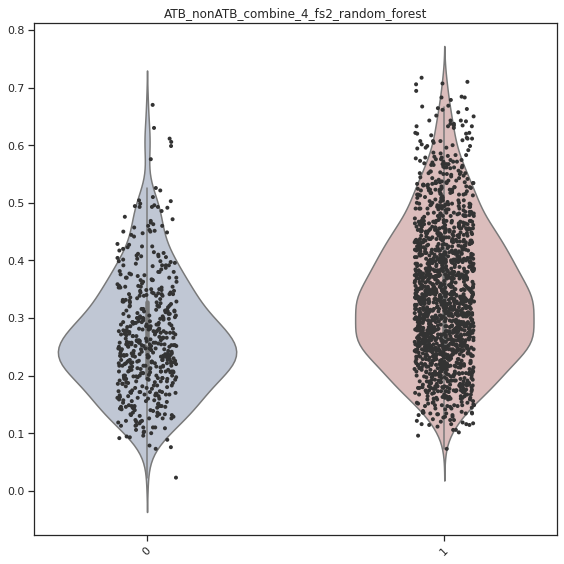

GSE101702_GPL21185
             age    disease  severity  gender tissue
GSM2712390  24.0  influenza   flu_mod  female  blood
GSM2712391  69.0  influenza   flu_mod    male  blood
GSM2712392  54.0  influenza  flu_svre    male  blood
GSM2712393  55.0  influenza   flu_mod  female  blood
GSM2712394  60.0  influenza   flu_mod  female  blood
GSM2712395  47.0  influenza   flu_mod    male  blood
GSM2712396  51.0  influenza   flu_mod  female  blood
GSM2712397  26.0  influenza   flu_mod  female  blood
GSM2712398  49.0  influenza   flu_mod    male  blood
GSE103842_GPL10558
                 age  disease viral_group  gender tissue
GSM2784290  0.183333  healthy     Control  female  blood
GSM2784291  0.330833  healthy     Control    male  blood
GSM2784292  0.514167  healthy     Control    male  blood
GSM2784293  0.527500  healthy     Control    male  blood
GSM2784294  0.560833  healthy     Control    male  blood
GSM2784295  0.577500  healthy     Control    male  blood
GSM2784296  0.735833  healthy    

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [27]:
for modelID in model_list.index:
    modelN=model_list.loc[modelID,'Group type']+'_'+'fs'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type']
    #load model
    select_fea,final_model,select_ml=gval.load_ml_model(
        model_list.loc[modelID,'Group type']+'_fs_'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type'], final_ml_dir)
    #Collect all study datasets
    all_info, all_gset=viral_infect_dataset(select_fea, rescale, 1)
    #predict 
    all_info['group']=1;all_info.loc[all_info['disease']=='healthy','group']=0
    all_gset=all_gset.loc[all_info.index,:]
    #Predict outcome given the whole data
    all_info=gval.modelscore(all_info, all_gset, model=final_model)
    #Visualize 
    ut.violinplot_compare(all_info, 'group', 'Y_pred', [0,1], modelN)
    
for modelID in pubmodel_list.index:
    modelN=pubmodel_list.loc[modelID,'model']
    select_fea=pubmodel_list.loc[modelID,'features'].split(',')
    #Collect all study datasets
    all_info, all_gset=viral_infect_dataset(select_fea, 0, 0)
    print(len(all_info.index))
    #predict 
    all_info['group']=1;all_info.loc[all_info['disease']=='healthy','group']=0
    all_gset=all_gset.loc[all_info.index,:]
    #Predict outcome given the whole data
    all_info=gval.modelscore(all_info, all_gset, pubmodel=1, model=modelN)
    #Visualize 
    ut.violinplot_compare(all_info, 'group', 'Y_pred', [0,1], modelN)     

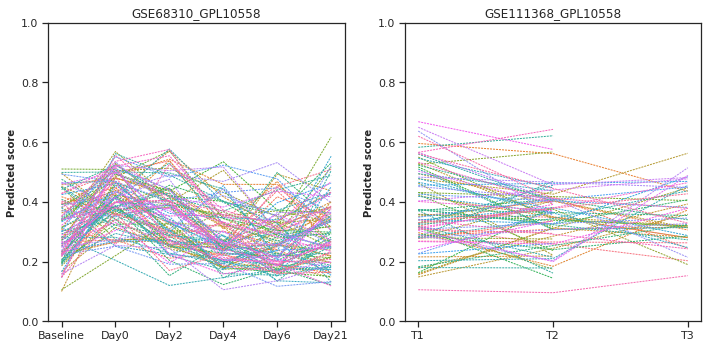

In [83]:
modelID=2
modelN=model_list.loc[modelID,'Group type']+'_'+'fs'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type']
#load model
select_fea,final_model,select_ml=gval.load_ml_model(
    model_list.loc[modelID,'Group type']+'_fs_'+str(model_list.loc[modelID,'Fea selection type'])+'_'+model_list.loc[modelID,'ML type'], final_ml_dir)

info, data=viral_data_extract('GSE68310_GPL10558',['gender:ch1','infection:ch1','subject id:ch1','time point:ch1'],['gender','disease','subjectID','timepoint'])    
data=gval.valdata_process(data,select_fea)
info['group']=1;info.loc[info['disease']=='healthy','group']=0
gset=data.loc[info.index,:]
info=gval.modelscore(info, gset, model=final_model)

info1, data1=viral_data_extract('GSE111368_GPL10558',['age:ch1','bacterial_status:ch1','day of illness:ch1','flu_type:ch1','Sex:ch1','subject id:ch1',
                            't1severity:ch1','timepoint:ch1'],['age','bacterial_status','day_illness','viral_group','gender','subjectID','severity','timepoint'])
data1=gval.valdata_process(data1,select_fea)
info1['group']=1;info1.loc[info1['disease']=='healthy','group']=0
gset1=data1.loc[info1.index,:]
info1=gval.modelscore(info1, gset1, model=final_model)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None,'expand_frame_repr', False):  
#   print(info1.loc[info1['disease']=='Influenza',:])



fig, axs = plt.subplots(1,2, figsize=(10,5));
sns.set_theme(style="ticks")
ax=axs[0]
subset1=pd.DataFrame([])
for ID in set(info['subjectID']):
    if info.loc[info['subjectID']==ID,:].shape[0]>1:#more than 1 timepoints 
        subset1=pd.concat([subset1,info.loc[info['subjectID']==ID,:]])
colors=ut.subject_linecolor()
sns.lineplot(x='timepoint', y='Y_pred', data=subset1, hue="subjectID", markers=False, style=True, dashes=[(2,1)], lw=1, legend=False, ax=ax)
ax.set_ylim([0,1])
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylabel('Predicted score', fontsize=10, weight='bold');ax.set_xlabel('')
ax.set_title('GSE68310_GPL10558')

ax=axs[1]
subset2=pd.DataFrame([])
for ID in set(info1.loc[info1['disease']=='Influenza','subjectID']):
    if info1.loc[info1['subjectID']==ID,:].shape[0]>2:#more than 1 timepoints 
        subset2=pd.concat([subset2,info1.loc[info1['subjectID']==ID,:]])
subset2 = subset2.sort_values(by ='timepoint')
colors=ut.subject_linecolor()
sns.lineplot(x='timepoint', y='Y_pred', data=subset2, hue="subjectID", markers=False, style=True, dashes=[(2,1)], lw=1, legend=False, ax=ax)
ax.set_ylim([0,1])
ax.set_xticks([0,1,2])
ax.set_ylabel('Predicted score', fontsize=10, weight='bold');ax.set_xlabel('')
ax.set_title('GSE111368_GPL10558')

plt.tight_layout()
plt.savefig(publication_dir+'/viral_infection_longitudinal.pdf')